In [5]:
import numpy as np
import tensorflow as tf
tf.compat.v1.logging.set_verbosity('ERROR')
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model
from collections import defaultdict, deque
from tqdm import tqdm
import matplotlib.pyplot as plt
from Environment_one_hot import *

In [6]:
LENGTH = 6000
WIDTH = 5000
DIVISION = 50
K = 6
NUM_BASE_STATIONS = 7

env = Environment(LENGTH, WIDTH, DIVISION, 1, 0, K)

Location and directions of cells are: 
{1: [0, 0, 0], 2: [0, 0, 1], 3: [0, 0, 2], 4: [1500.0, 0, 0], 5: [1500.0, 0, 1], 6: [1500.0, 0, 2], 7: [750.0, 1250.0, 0], 8: [750.0, 1250.0, 1], 9: [750.0, 1250.0, 2], 10: [-750.0, 1250.0, 0], 11: [-750.0, 1250.0, 1], 12: [-750.0, 1250.0, 2], 13: [-1500.0, 0, 0], 14: [-1500.0, 0, 1], 15: [-1500.0, 0, 2], 16: [-750.0, -1250.0, 0], 17: [-750.0, -1250.0, 1], 18: [-750.0, -1250.0, 2], 19: [750.0, -1250.0, 0], 20: [750.0, -1250.0, 1], 21: [750.0, -1250.0, 2]} 
 

Strongest cells for sector (0, 0)
[[13.0, -71.57537341908636], [10.0, -76.12999350009669], [20.0, -76.90120662911897], [9.0, -77.11602377321972], [5.0, -77.38328723526723], [16.0, -78.29258258665135]]


Strongest cells for sector (0, 100)
[[5.0, -65.5702069842443], [13.0, -73.60319869220947], [20.0, -81.14784356283874], [2.0, -81.68318639053], [9.0, -83.96589112982258], [17.0, -88.8430636653547]]


Strongest cells for sector (50, 0)
[[5.0, -68.48868361552624], [13.0, -71.33303432876677], [16.

In [7]:
class Agent:
    def __init__(self, k, NUM_BASE_STATIONS):
        self.k = k
        cells = 3*NUM_BASE_STATIONS
        num_inputs = 2 + 8 + cells
        # Model
        #--------------------------------------------------------------------
        input_A = Input(shape = num_inputs) #(x, y, direction, current_serving_cell_one_hot_encoded)
        x = Dense(32)(input_A)
        x = LeakyReLU()(x)
        x = Dense(64)(x)
        x = LeakyReLU()(x)
        x = Dense(32)(x)
        x = LeakyReLU()(x)
        x = Dense(self.k, 'tanh')(x)
        x = tf.math.multiply(x, 10)
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #--------------------------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
        
        self.batch_size = 128
        self.epsilon = 1
        self.gamma = 0.3
        self.replay_buffer_size = 1024
        
        #Replay Buffers
        self.action_history = deque(maxlen = self.replay_buffer_size)
        self.state_history = deque(maxlen = self.replay_buffer_size)
        self.next_state_history = deque(maxlen = self.replay_buffer_size)
        self.rewards_history = deque(maxlen = self.replay_buffer_size)
        self.done_history = deque(maxlen = self.replay_buffer_size)

        
    def play_one_step(self, state, route, dest, Wrsrp, Who, baseline = False):
        if not baseline:
            action = self.exp_policy(state)
        else:
            action = 0
            
        next_state, reward, done, change = env.step(state, route, action, dest)
        next_state = list(next_state)
        reward*=Wrsrp
        reward-=change*Who
        
        self.append_replay_buffer(state, action, next_state, reward, done)
        return next_state, reward, done, change
    
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(self.k)
        else:
            normalised_state = self.normalise_inputs(np.array(state)[np.newaxis])
            Q_values = self.model(normalised_state)
            return np.argmax(Q_values[0])
        
    def append_replay_buffer(self, state, action, next_state, reward, done):
        self.state_history.append(state)
        self.action_history.append(action)
        self.next_state_history.append(next_state)
        self.rewards_history.append(reward)
        self.done_history.append(done)
        
    def sample_experience(self):
        indices = np.random.randint(len(self.state_history), size = self.batch_size)
        
        states = np.array([self.state_history[i] for i in indices])
        actions = np.array([self.action_history[i] for i in indices])
        next_states = np.array([self.next_state_history[i] for i in indices])
        rewards = np.array([self.rewards_history[i] for i in indices])
        dones = np.array([self.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
        
    
    def training_step(self, num_training_episode):
        for _ in range(num_training_episode):
            states, actions, next_states, rewards, dones = self.sample_experience()

            states = self.normalise_inputs(states)
            next_states = self.normalise_inputs(next_states)

            next_Q_values = self.target_model(next_states)
            max_next_Q_values = np.max(next_Q_values, axis= 1)

            target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
            mask = tf.one_hot(actions, self.k)

            with tf.GradientTape() as tape:
                all_Q_values = self.model(states)
                Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
                loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

            grads = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        
    def normalise_inputs(self, states):
        '''Normalising the inputs to the NN'''
        states = states.astype('float')
        states[:,0]/=(LENGTH/2)
        states[:,1]/=(WIDTH/2)
        states = tf.convert_to_tensor(states)
        
        return states
        
        
        

In [8]:
agent_0 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)               

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

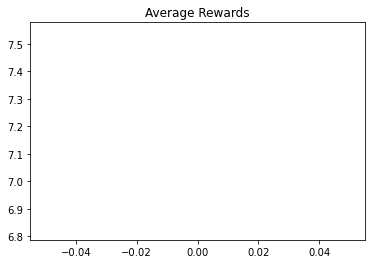

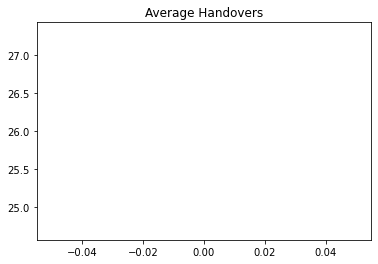

  5%|███▊                                                                         | 1000/20000 [01:38<26:21, 12.01it/s]

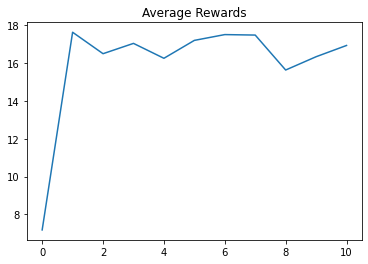

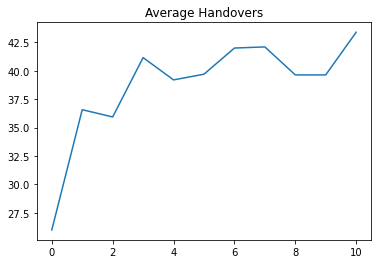

  5%|███▊                                                                         | 1002/20000 [01:38<40:39,  7.79it/s]

Saved new weights for reward of 16.930549699647713


  6%|████▋                                                                        | 1202/20000 [01:58<28:55, 10.83it/s]

Saved new weights for reward of 17.258063139128016


 10%|███████▋                                                                     | 2000/20000 [03:18<31:15,  9.60it/s]

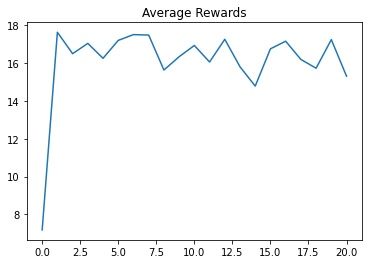

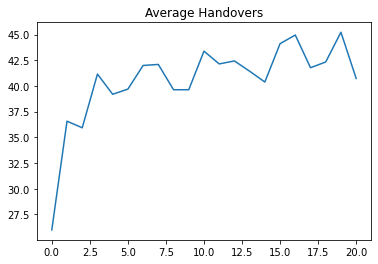

 14%|██████████▊                                                                  | 2802/20000 [04:37<33:13,  8.63it/s]

Saved new weights for reward of 17.40351676303627


 15%|███████████▌                                                                 | 2999/20000 [04:56<27:30, 10.30it/s]

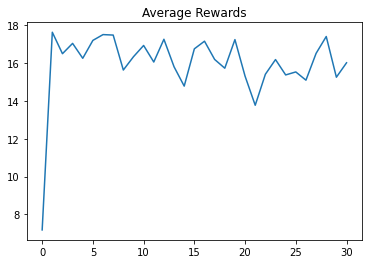

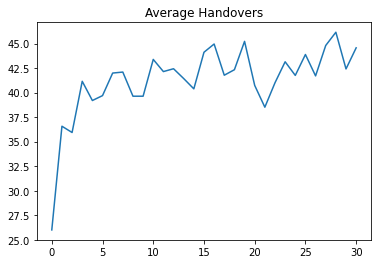

 20%|███████████████▍                                                             | 3999/20000 [06:34<23:17, 11.45it/s]

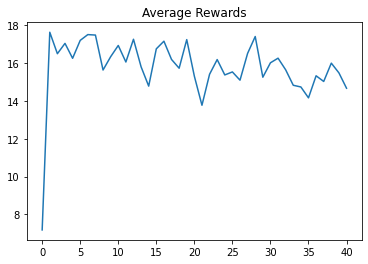

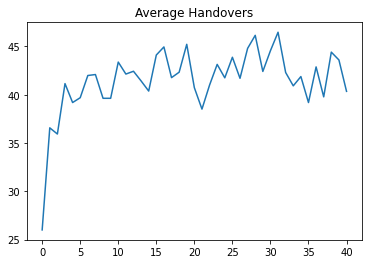

 25%|███████████████████▎                                                         | 5000/20000 [08:10<22:22, 11.17it/s]

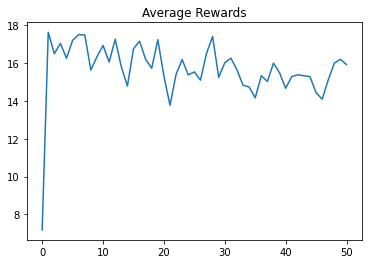

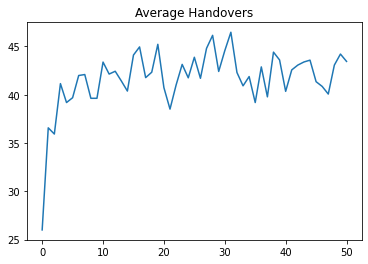

 30%|███████████████████████                                                      | 5999/20000 [09:47<22:03, 10.58it/s]

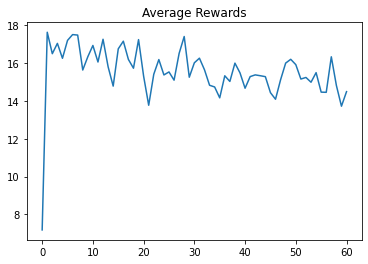

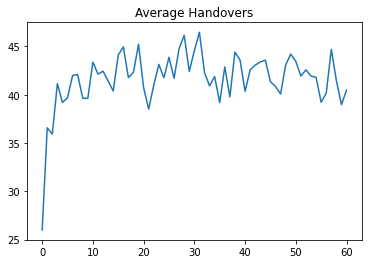

 35%|██████████████████████████▉                                                  | 6999/20000 [11:25<20:43, 10.45it/s]

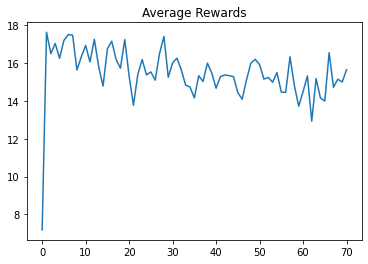

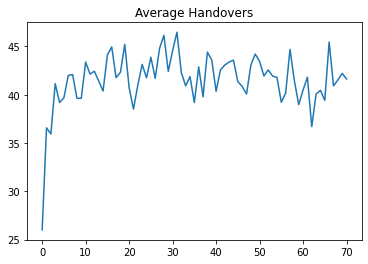

 40%|██████████████████████████████▊                                              | 8000/20000 [13:00<18:27, 10.84it/s]

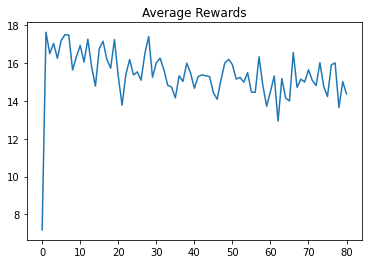

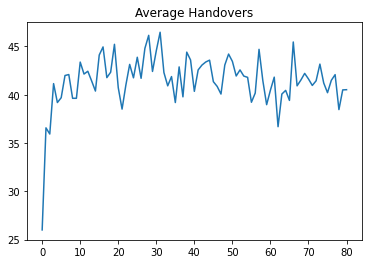

 45%|██████████████████████████████████▋                                          | 8999/20000 [14:37<15:02, 12.19it/s]

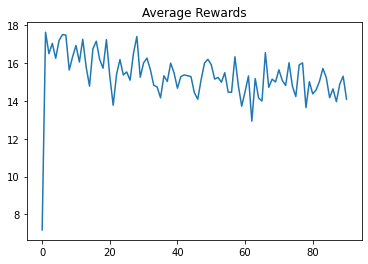

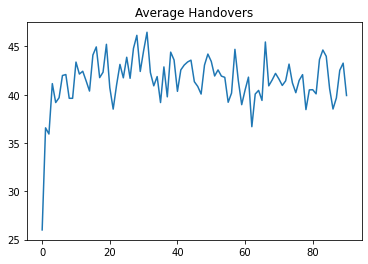

 50%|██████████████████████████████████████                                      | 10000/20000 [16:13<17:57,  9.28it/s]

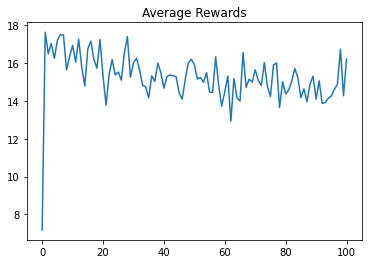

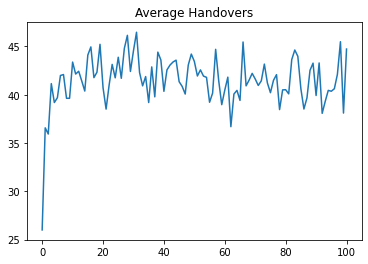

 55%|█████████████████████████████████████████▊                                  | 10999/20000 [17:50<15:35,  9.63it/s]

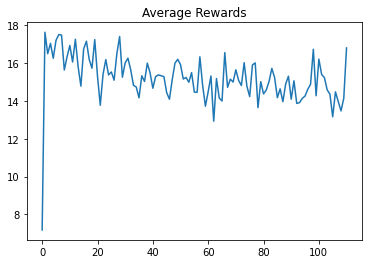

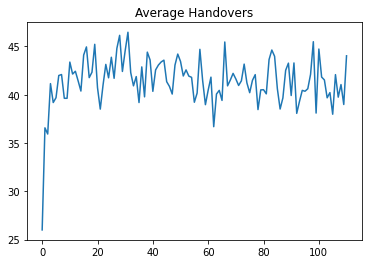

 60%|█████████████████████████████████████████████▌                              | 11999/20000 [19:25<12:17, 10.85it/s]

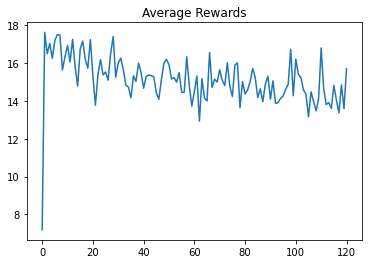

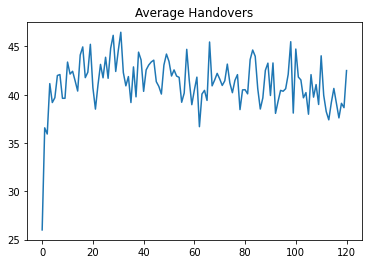

 65%|█████████████████████████████████████████████████▍                          | 12999/20000 [21:04<11:58,  9.75it/s]

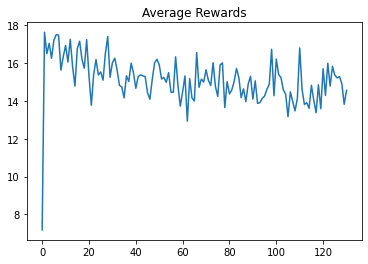

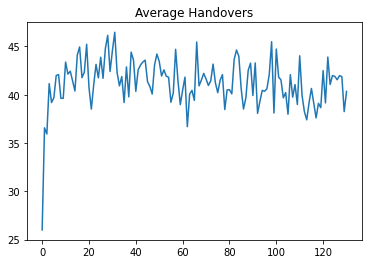

 70%|█████████████████████████████████████████████████████▏                      | 14000/20000 [22:40<10:30,  9.52it/s]

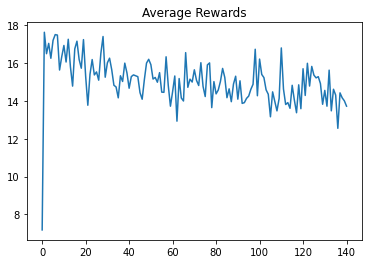

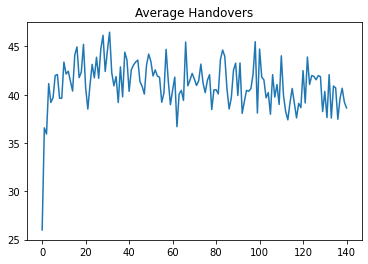

 75%|████████████████████████████████████████████████████████▉                   | 14999/20000 [24:15<07:12, 11.56it/s]

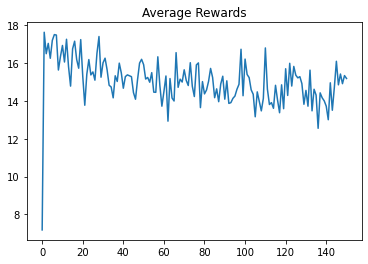

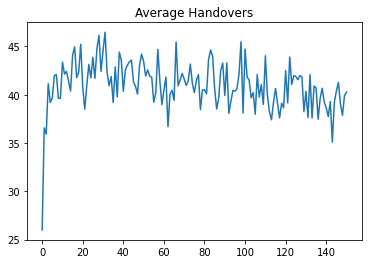

 80%|████████████████████████████████████████████████████████████▊               | 16000/20000 [25:52<06:39, 10.01it/s]

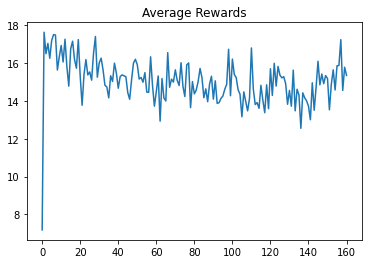

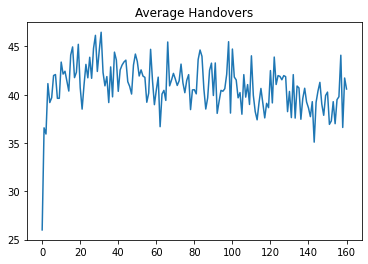

 85%|████████████████████████████████████████████████████████████████▌           | 17000/20000 [27:31<06:04,  8.24it/s]

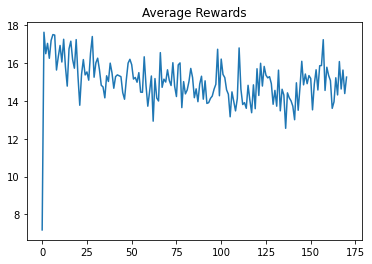

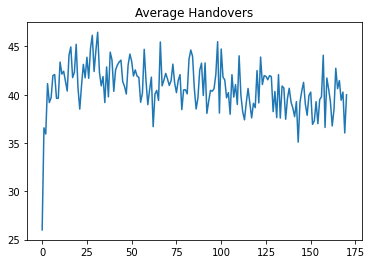

 90%|████████████████████████████████████████████████████████████████████▍       | 18000/20000 [29:08<03:05, 10.79it/s]

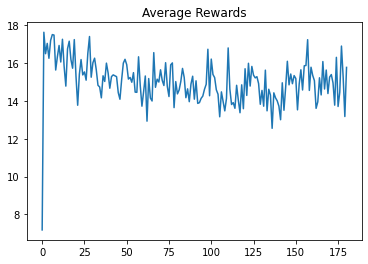

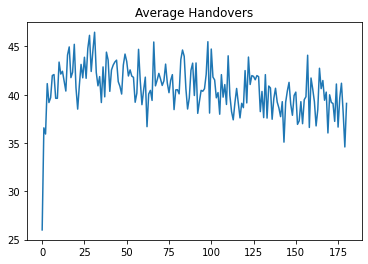

 95%|████████████████████████████████████████████████████████████████████████▏   | 18999/20000 [30:44<01:37, 10.30it/s]

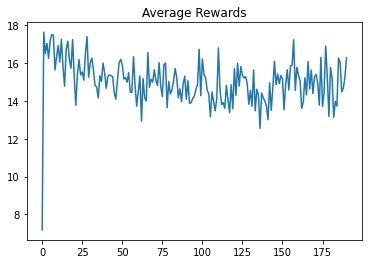

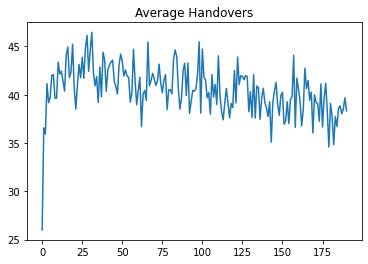

 97%|█████████████████████████████████████████████████████████████████████████▎  | 19302/20000 [31:15<00:59, 11.64it/s]

Saved new weights for reward of 17.90001548990175


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [32:23<00:00, 10.29it/s]


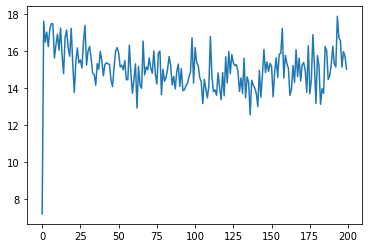

15.034560985613398


In [9]:
agent = agent_0
Wrsrp = 1
Who = 0
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1 #training steps per episode
target_model_update = 10
max_reward = float('-inf')
path = 'agent_0.h5'

for episode in tqdm(range(20000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        if change:
            num_hos+=1
        state = next_state
        
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')

    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [10]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        if change:
            num_hos +=1
        state = next_state
        
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:13<00:00, 15.03it/s]

17.99347147801093
36.868


In [7]:
agent_19 = Agent(6, NUM_BASE_STATIONS)
#lr = 0.005, 0.001, batch_size = 256, same for agent_0
#epsilon = 1

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)               

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

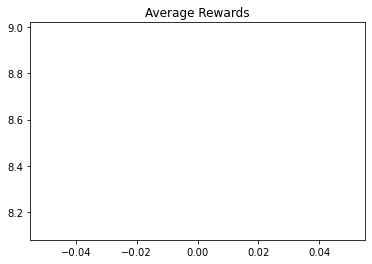

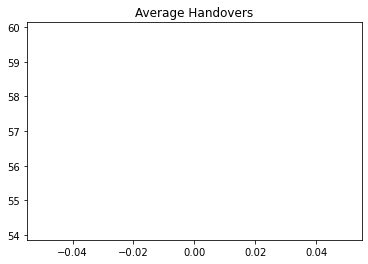

  5%|███▊                                                                         | 1000/20000 [01:27<26:08, 12.11it/s]

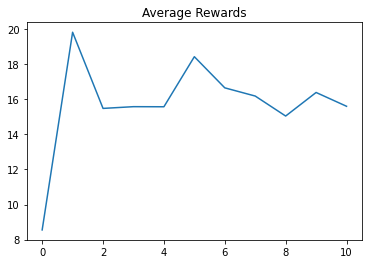

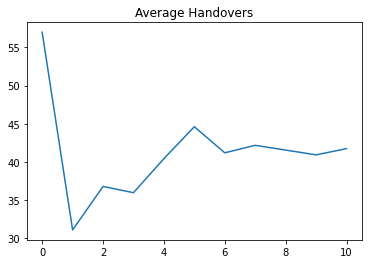

  5%|███▊                                                                         | 1002/20000 [01:28<42:37,  7.43it/s]

Saved new weights for reward of 15.604269786323522


  6%|████▌                                                                        | 1201/20000 [01:46<30:44, 10.19it/s]

Saved new weights for reward of 15.689458018781504


  7%|█████                                                                        | 1302/20000 [01:55<28:09, 11.07it/s]

Saved new weights for reward of 16.846051044013233


 10%|███████▋                                                                     | 2000/20000 [02:53<28:57, 10.36it/s]

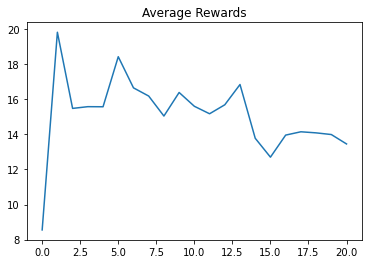

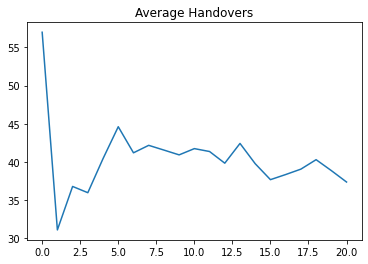

 15%|███████████▌                                                                 | 3000/20000 [04:19<36:27,  7.77it/s]

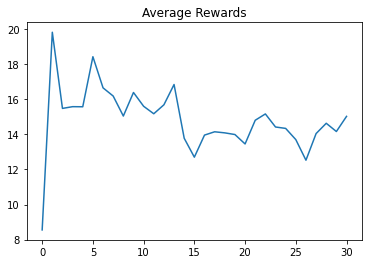

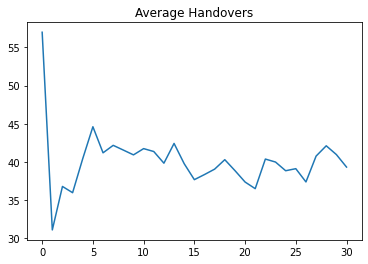

 20%|███████████████▍                                                             | 3999/20000 [06:36<39:05,  6.82it/s]

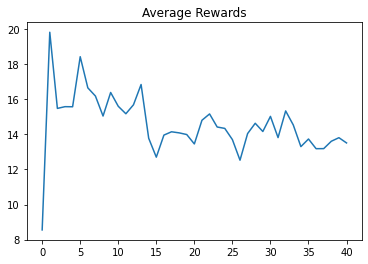

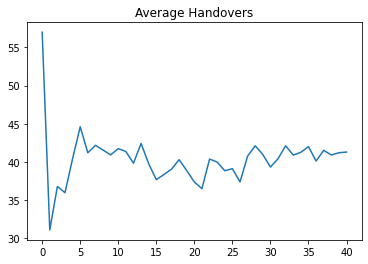

 25%|███████████████████▏                                                         | 4999/20000 [08:49<34:36,  7.22it/s]

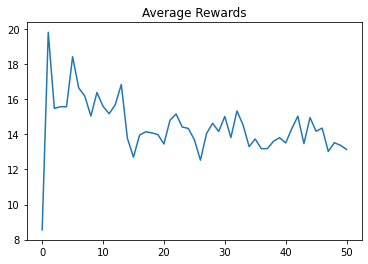

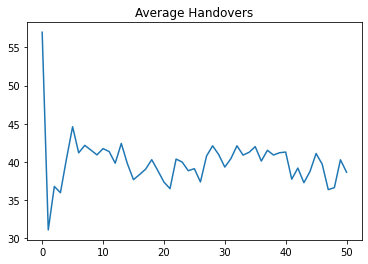

 30%|███████████████████████                                                      | 5999/20000 [10:39<17:52, 13.06it/s]

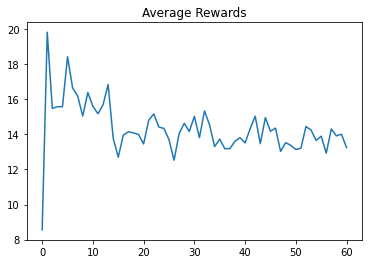

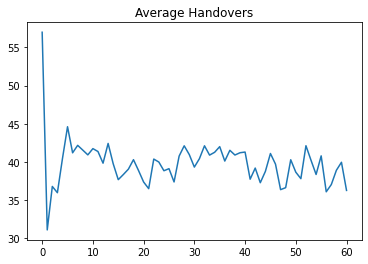

 34%|██████████████████████████▏                                                  | 6802/20000 [11:48<19:09, 11.48it/s]

Saved new weights for reward of 16.944394046158788


 35%|██████████████████████████▉                                                  | 6999/20000 [12:04<16:30, 13.12it/s]

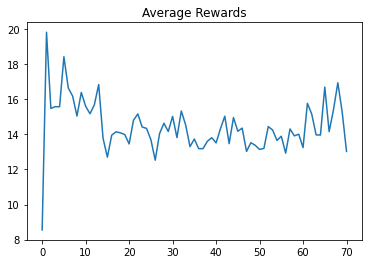

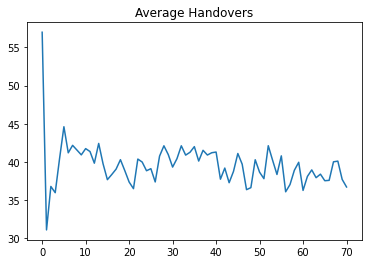

 39%|█████████████████████████████▋                                               | 7703/20000 [13:06<20:03, 10.22it/s]

Saved new weights for reward of 17.104711885942407


 40%|██████████████████████████████▊                                              | 8000/20000 [13:32<18:07, 11.04it/s]

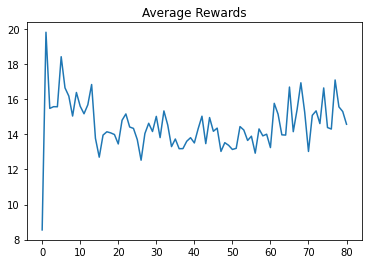

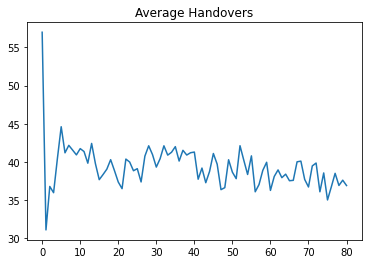

 45%|██████████████████████████████████▋                                          | 9000/20000 [15:26<24:40,  7.43it/s]

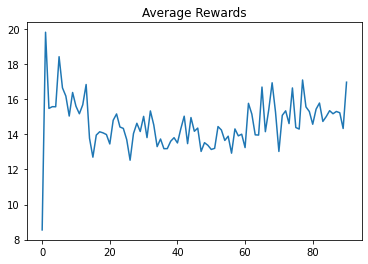

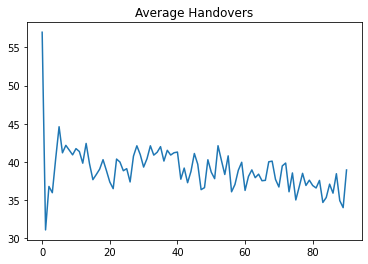

 50%|██████████████████████████████████████                                      | 10000/20000 [17:46<27:42,  6.01it/s]

Saved new weights for reward of 17.806372128709075


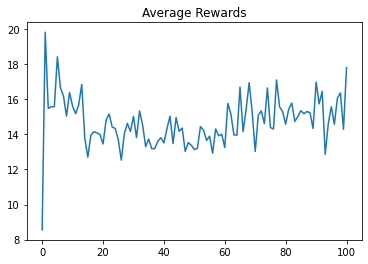

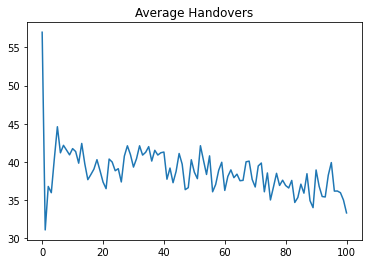

 55%|█████████████████████████████████████████▍                                  | 10902/20000 [19:39<22:16,  6.81it/s]

Saved new weights for reward of 18.474257422979566


 55%|█████████████████████████████████████████▊                                  | 11000/20000 [19:48<14:56, 10.04it/s]

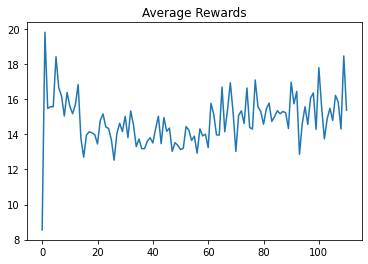

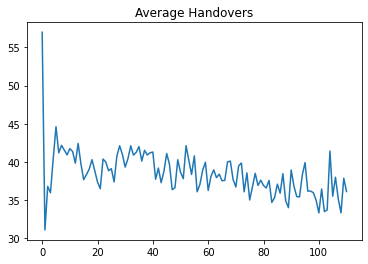

 60%|█████████████████████████████████████████████▌                              | 11999/20000 [21:12<12:40, 10.53it/s]

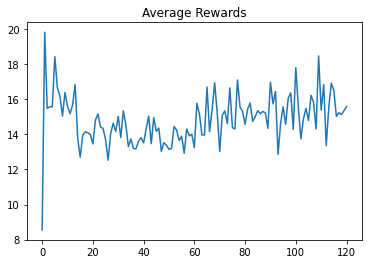

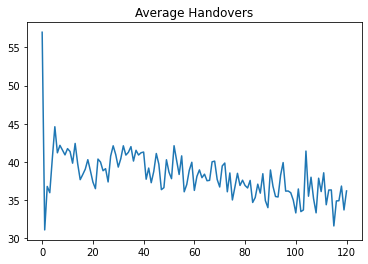

 65%|█████████████████████████████████████████████████▍                          | 12999/20000 [22:42<13:31,  8.63it/s]

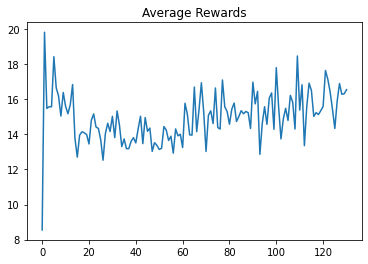

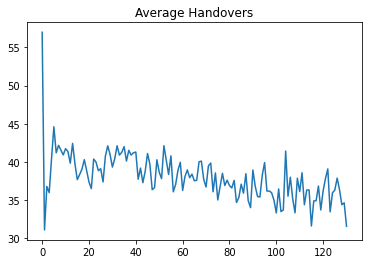

 70%|█████████████████████████████████████████████████████▏                      | 13999/20000 [24:11<09:42, 10.30it/s]

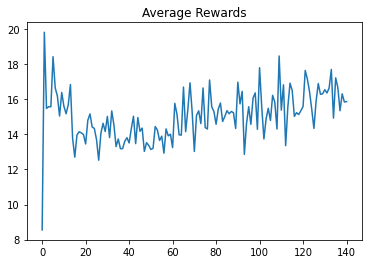

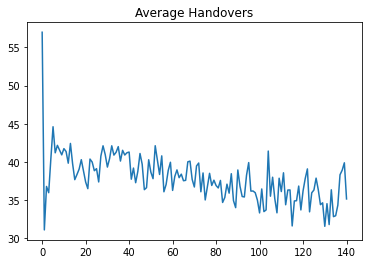

 75%|█████████████████████████████████████████████████████████                   | 15000/20000 [26:04<10:16,  8.11it/s]

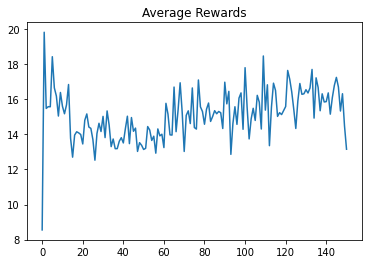

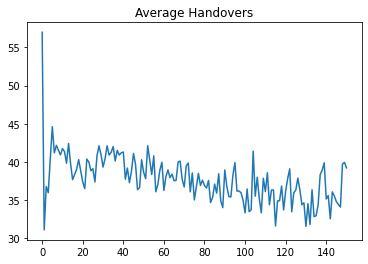

 80%|████████████████████████████████████████████████████████████▊               | 15999/20000 [28:25<07:29,  8.90it/s]

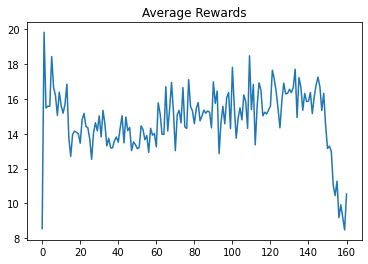

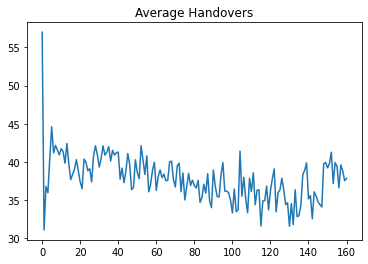

 85%|████████████████████████████████████████████████████████████████▌           | 17000/20000 [30:10<03:53, 12.84it/s]

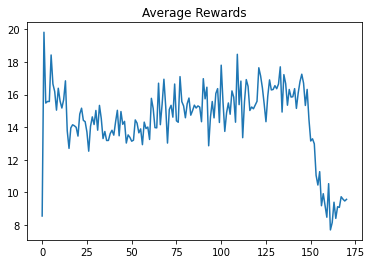

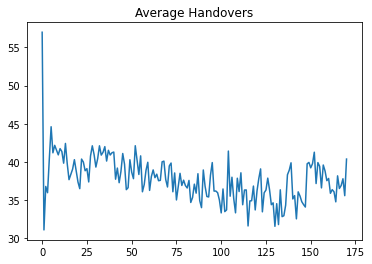

 90%|████████████████████████████████████████████████████████████████████▍       | 17999/20000 [31:35<02:46, 12.05it/s]

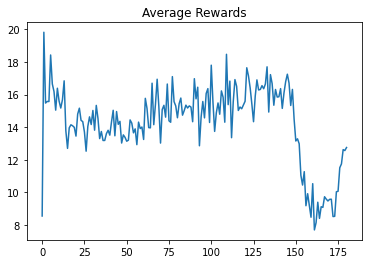

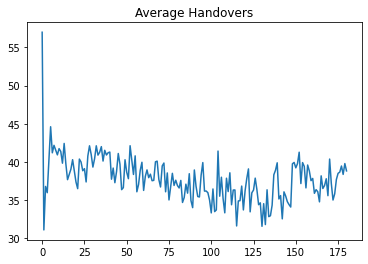

 95%|████████████████████████████████████████████████████████████████████████▏   | 18999/20000 [33:02<01:22, 12.09it/s]

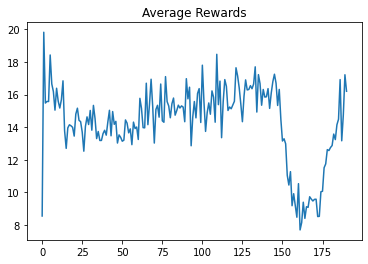

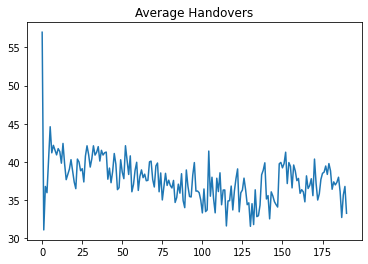

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [34:25<00:00,  9.68it/s]


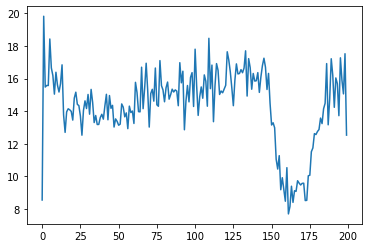

12.531638499146894


In [8]:
agent = agent_19
Wrsrp = 1
Who = 1/9
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1 #training steps per episode
target_model_update = 100
max_reward = float('-inf')
path = 'agent_19.h5'

for episode in tqdm(range(20000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0

    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [9]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:43<00:00, 19.29it/s]

23.440601249078963
25.933


In [11]:
agent_1_1 = Agent(6, NUM_BASE_STATIONS)
#lr = 0.0005, batch_size = 1024

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32)               

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

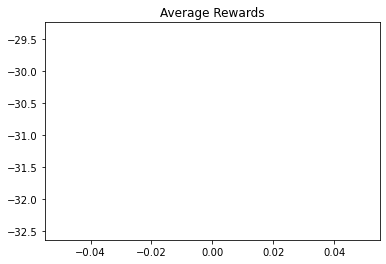

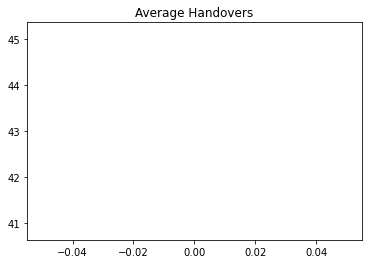

  5%|███▊                                                                         | 1000/20000 [01:21<23:36, 13.41it/s]

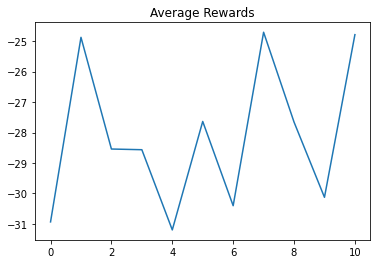

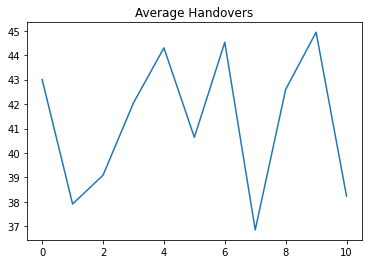

  5%|███▊                                                                         | 1002/20000 [01:22<37:08,  8.52it/s]

Saved new weights for reward of -24.787171038068507


 10%|███████▋                                                                     | 1999/20000 [02:49<22:19, 13.44it/s]

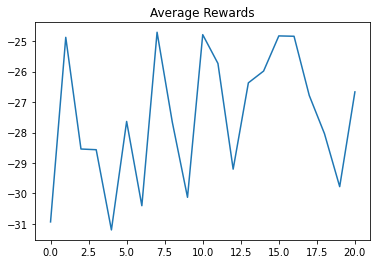

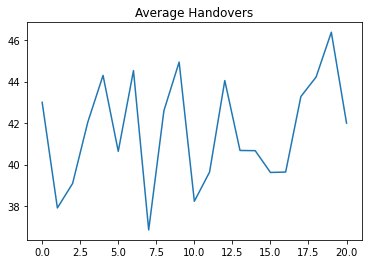

 12%|████████▊                                                                    | 2302/20000 [03:14<23:51, 12.36it/s]

Saved new weights for reward of -24.390605373387242


 15%|███████████▌                                                                 | 2999/20000 [04:11<22:31, 12.58it/s]

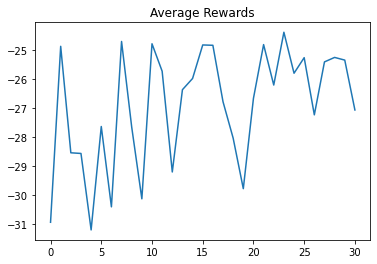

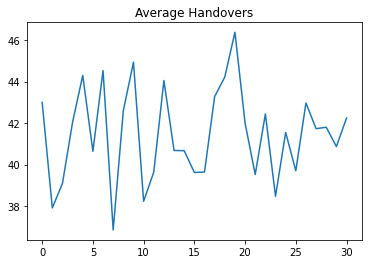

 16%|████████████▎                                                                | 3203/20000 [04:29<24:31, 11.41it/s]

Saved new weights for reward of -23.995055212786898


 18%|█████████████▊                                                               | 3603/20000 [05:01<21:03, 12.98it/s]

Saved new weights for reward of -23.346628483539433


 20%|███████████████▍                                                             | 4000/20000 [05:33<20:52, 12.77it/s]

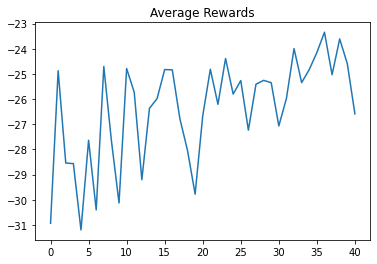

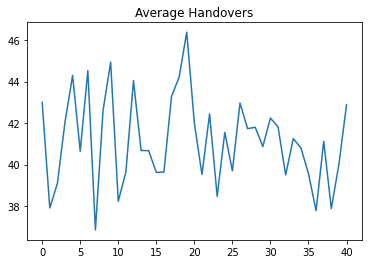

 24%|██████████████████                                                           | 4702/20000 [06:32<22:19, 11.42it/s]

Saved new weights for reward of -22.954944679712266


 25%|███████████████████▎                                                         | 5000/20000 [06:56<20:45, 12.04it/s]

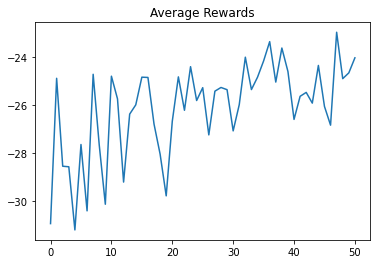

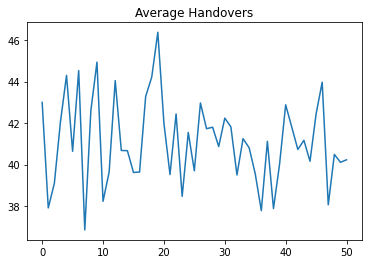

 30%|███████████████████████                                                      | 6000/20000 [08:20<19:41, 11.85it/s]

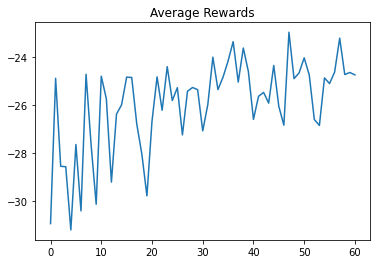

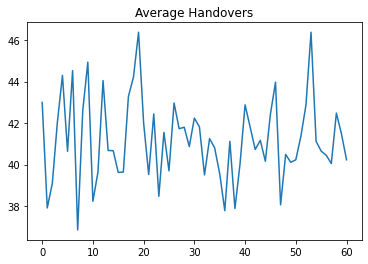

 35%|██████████████████████████▉                                                  | 7000/20000 [09:43<15:22, 14.09it/s]

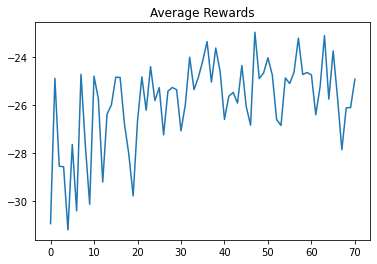

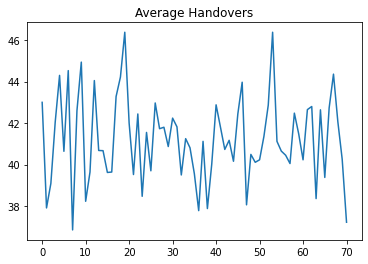

 40%|██████████████████████████████▊                                              | 8000/20000 [11:06<16:50, 11.87it/s]

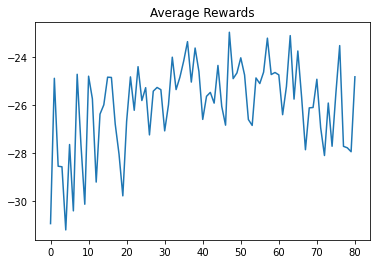

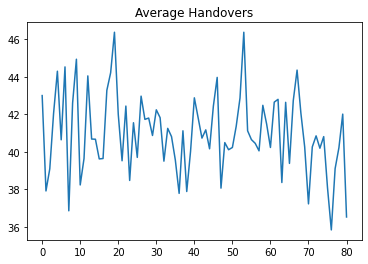

 45%|██████████████████████████████████▋                                          | 8999/20000 [12:29<13:29, 13.58it/s]

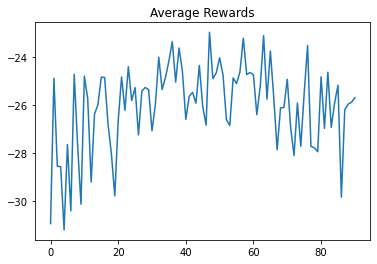

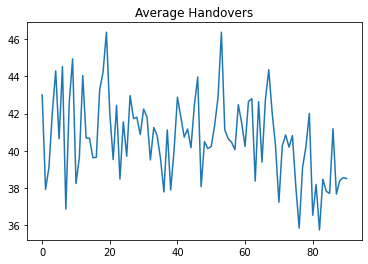

 50%|██████████████████████████████████████▍                                      | 9999/20000 [13:52<12:17, 13.56it/s]

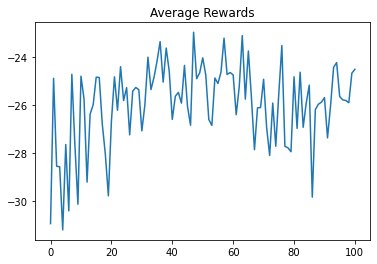

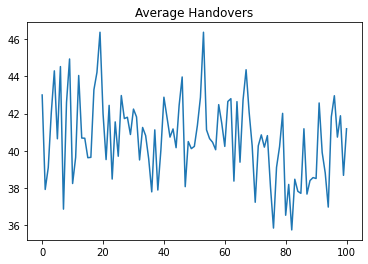

 51%|██████████████████████████████████████▍                                     | 10101/20000 [14:01<13:48, 11.94it/s]

Saved new weights for reward of -21.47390007637184


 52%|███████████████████████████████████████▏                                    | 10303/20000 [14:17<11:38, 13.88it/s]

Saved new weights for reward of -21.049079255530543


 55%|█████████████████████████████████████████▊                                  | 10999/20000 [15:14<14:51, 10.10it/s]

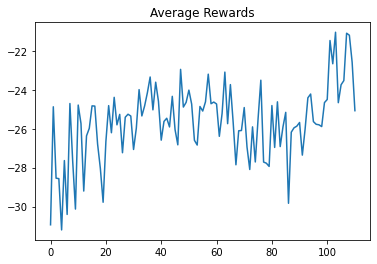

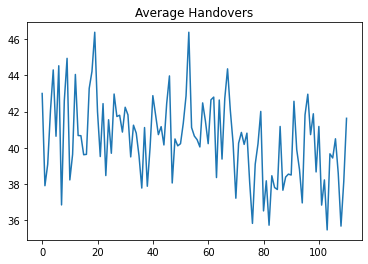

 60%|█████████████████████████████████████████████▌                              | 12000/20000 [16:38<11:32, 11.55it/s]

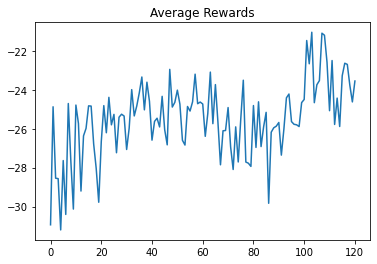

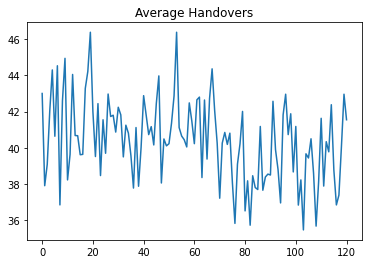

 61%|█████████████████████████████████████████████▉                              | 12102/20000 [16:46<10:11, 12.91it/s]

Saved new weights for reward of -20.21311732397105


 64%|████████████████████████████████████████████████▎                           | 12703/20000 [17:36<10:48, 11.26it/s]

Saved new weights for reward of -19.295667594585005


 65%|█████████████████████████████████████████████████▍                          | 13000/20000 [18:00<10:00, 11.65it/s]

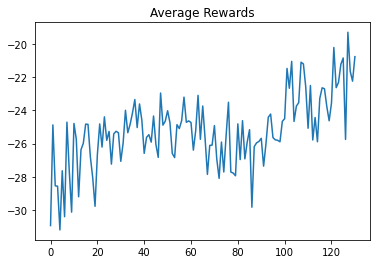

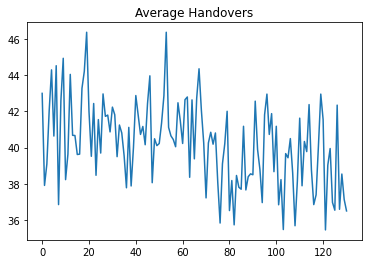

 70%|█████████████████████████████████████████████████████▏                      | 13999/20000 [19:25<08:17, 12.07it/s]

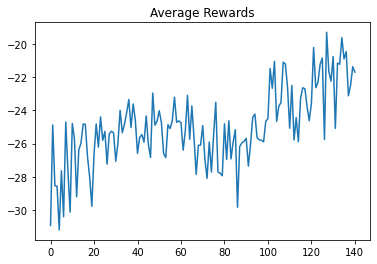

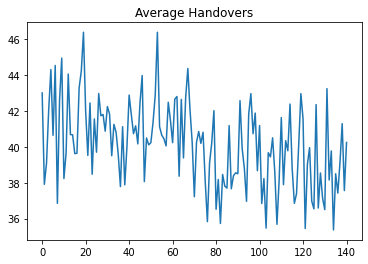

 72%|██████████████████████████████████████████████████████▎                     | 14302/20000 [19:50<07:18, 12.98it/s]

Saved new weights for reward of -17.52068155489504


 72%|██████████████████████████████████████████████████████▋                     | 14402/20000 [19:58<08:21, 11.17it/s]

Saved new weights for reward of -16.61310788294624


 75%|█████████████████████████████████████████████████████████                   | 15000/20000 [20:48<07:54, 10.54it/s]

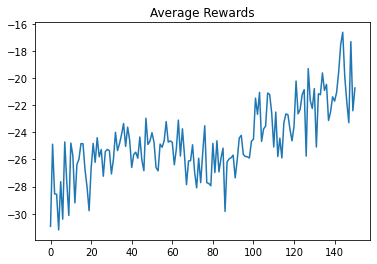

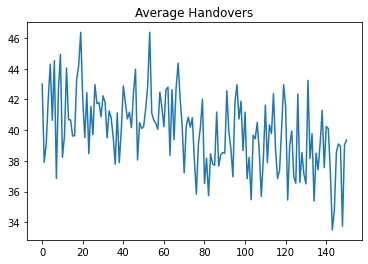

 78%|███████████████████████████████████████████████████████████▎                | 15602/20000 [21:38<06:18, 11.62it/s]

Saved new weights for reward of -13.033757053379352


 80%|████████████████████████████████████████████████████████████▊               | 16000/20000 [22:13<06:02, 11.04it/s]

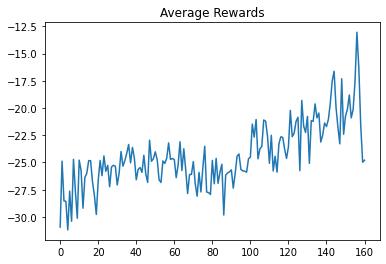

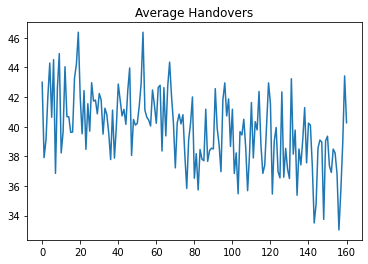

 85%|████████████████████████████████████████████████████████████████▌           | 17000/20000 [23:36<03:56, 12.66it/s]

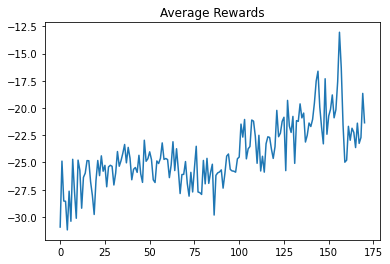

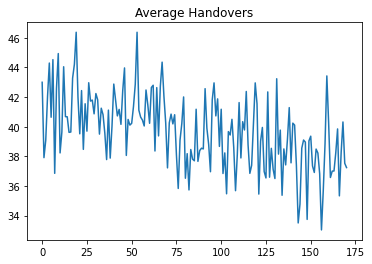

 90%|████████████████████████████████████████████████████████████████████▍       | 17999/20000 [24:59<03:08, 10.60it/s]

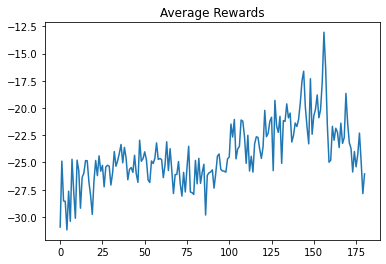

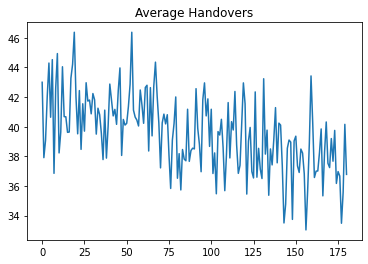

 95%|████████████████████████████████████████████████████████████████████████▏   | 19000/20000 [26:26<01:31, 10.95it/s]

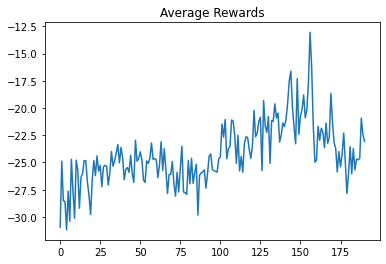

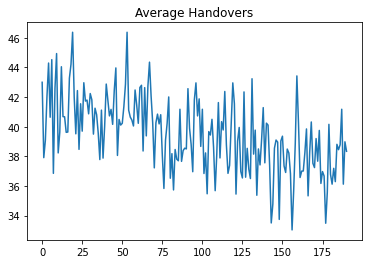

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [28:12<00:00, 11.81it/s]


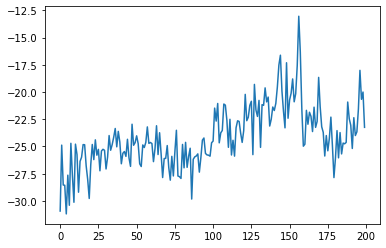

-23.2414439116695


In [12]:
agent = agent_1_1
Wrsrp = 1
Who = 1
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_1_1.h5'

for episode in tqdm(range(20000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [13]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:55<00:00, 17.34it/s]

-2.199504903652775
27.9165


In [14]:
agent_baseline = Agent(6, NUM_BASE_STATIONS)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32)               

In [15]:
agent = agent_baseline
Wrsrp = 1
Who = 0
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell)#Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who, baseline = True)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

print(np.mean(rewards))
print(np.mean(hos))

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 871.65it/s]

28.33030334501878
24.51


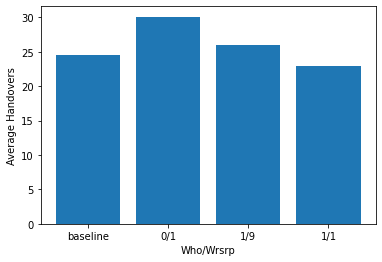

In [17]:
vals = [np.mean(hos), agent_0.mean_hos, agent_19.mean_hos,agent_1_1.mean_hos]
name = ['baseline', '0/1', '1/9', '1/1']
plt.bar(name, vals)
plt.ylabel('Average Handovers')
plt.xlabel('Who/Wrsrp')
plt.show()

In [20]:
agent_13 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 32)              

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

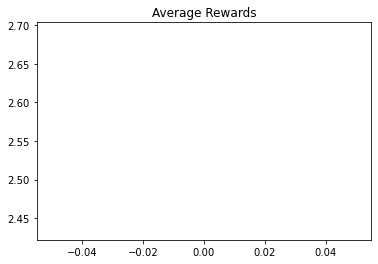

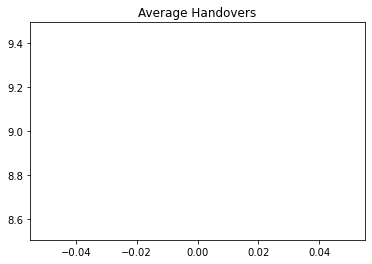

  5%|███▉                                                                          | 999/20000 [01:24<24:46, 12.79it/s]

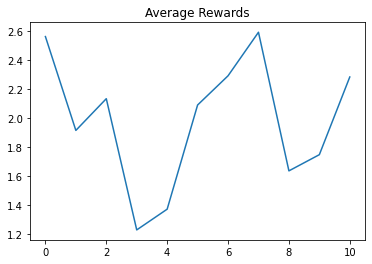

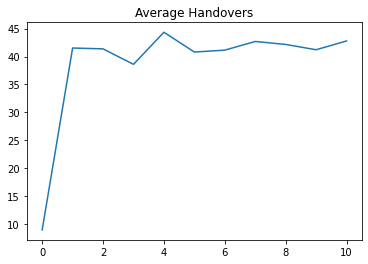

  5%|███▊                                                                         | 1003/20000 [01:25<38:45,  8.17it/s]

Saved new weights for reward of 2.2836015651078947


  8%|██████▏                                                                      | 1602/20000 [02:17<32:33,  9.42it/s]

Saved new weights for reward of 2.435577230828805


  9%|██████▌                                                                      | 1702/20000 [02:27<29:27, 10.35it/s]

Saved new weights for reward of 2.7058716858376477


 10%|███████▎                                                                     | 1903/20000 [02:46<27:14, 11.07it/s]

Saved new weights for reward of 2.727247026744852


 10%|███████▋                                                                     | 2000/20000 [02:54<20:51, 14.38it/s]

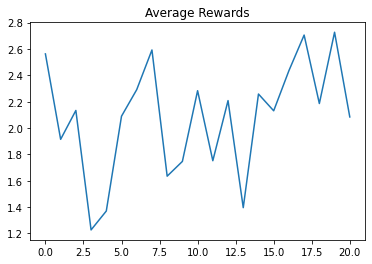

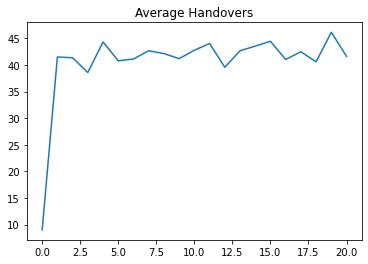

 11%|████████                                                                     | 2103/20000 [03:03<27:06, 11.00it/s]

Saved new weights for reward of 2.832942490753922


 11%|████████▍                                                                    | 2202/20000 [03:11<22:41, 13.07it/s]

Saved new weights for reward of 2.9035088712064208


 14%|██████████▊                                                                  | 2802/20000 [04:02<29:07,  9.84it/s]

Saved new weights for reward of 2.996273161334082


 15%|███████████▏                                                                 | 2901/20000 [04:11<24:28, 11.64it/s]

Saved new weights for reward of 3.3729359916696815


 15%|███████████▌                                                                 | 2999/20000 [04:19<22:28, 12.61it/s]

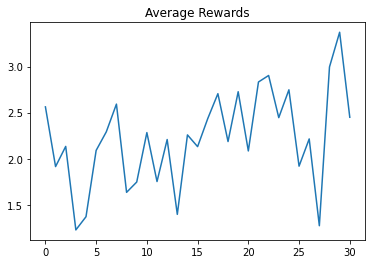

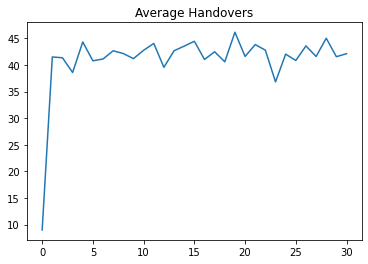

 20%|███████████████▍                                                             | 4000/20000 [05:49<23:40, 11.27it/s]

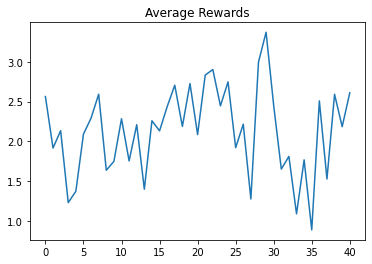

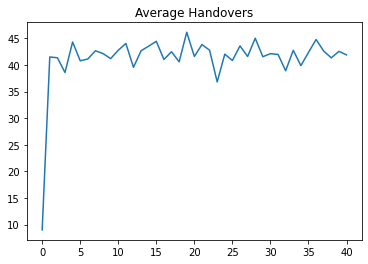

 25%|███████████████████▏                                                         | 4999/20000 [07:15<21:11, 11.80it/s]

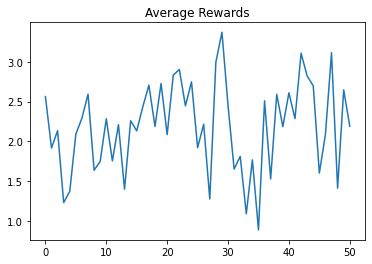

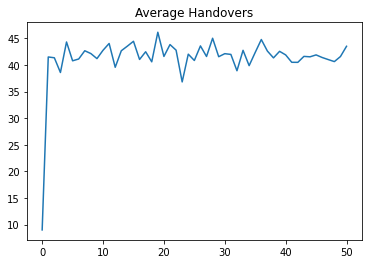

 29%|█████████████████████▉                                                       | 5702/20000 [08:16<21:17, 11.20it/s]

Saved new weights for reward of 3.5910197869408473


 30%|██████████████████████▋                                                      | 5902/20000 [08:34<23:01, 10.21it/s]

Saved new weights for reward of 4.496370302559004


 30%|███████████████████████                                                      | 5999/20000 [08:43<16:47, 13.89it/s]

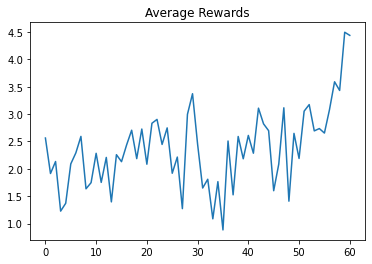

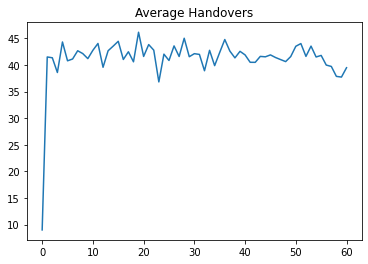

 35%|██████████████████████████▉                                                  | 6999/20000 [10:07<17:20, 12.50it/s]

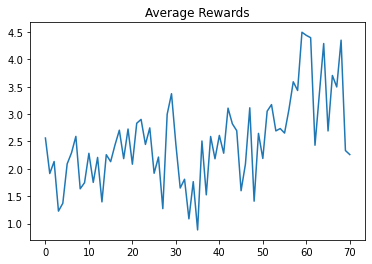

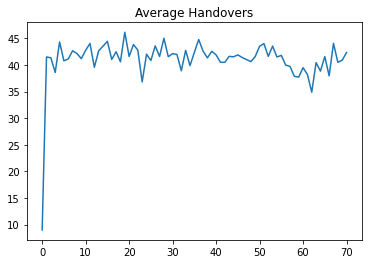

 40%|██████████████████████████████▊                                              | 7999/20000 [11:31<17:25, 11.48it/s]

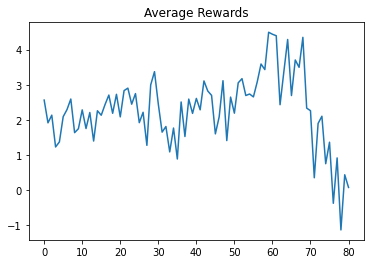

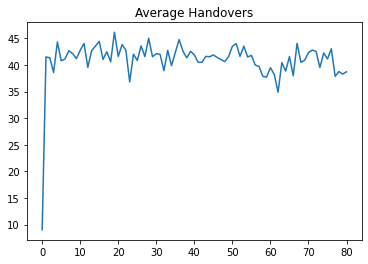

 45%|██████████████████████████████████▎                                          | 8903/20000 [12:47<16:57, 10.91it/s]

Saved new weights for reward of 4.782885891566766


 45%|██████████████████████████████████▋                                          | 8999/20000 [12:55<15:16, 12.01it/s]

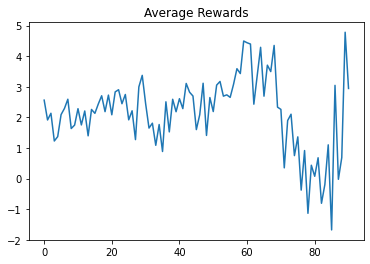

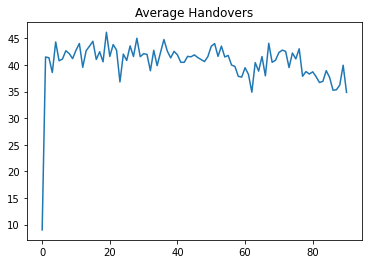

 46%|███████████████████████████████████                                          | 9103/20000 [13:04<15:49, 11.48it/s]

Saved new weights for reward of 6.405589495721513


 50%|██████████████████████████████████████                                       | 9902/20000 [14:10<14:40, 11.47it/s]

Saved new weights for reward of 6.4817245694428856


 50%|██████████████████████████████████████                                      | 10000/20000 [14:19<12:48, 13.01it/s]

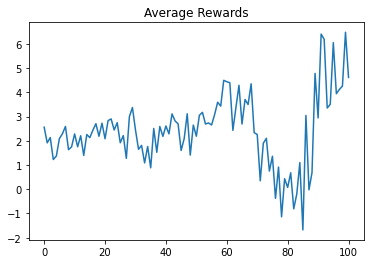

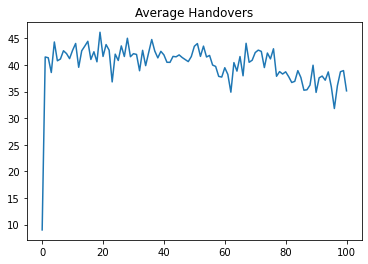

 55%|█████████████████████████████████████████▊                                  | 10999/20000 [15:40<12:27, 12.04it/s]

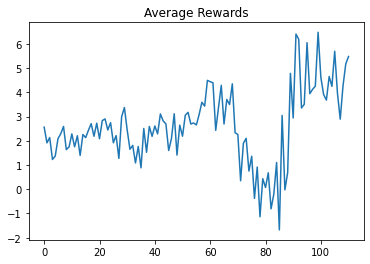

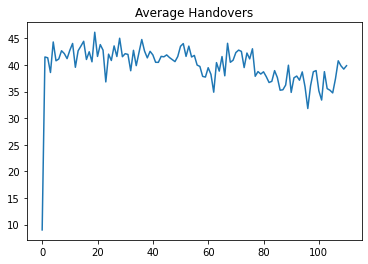

 59%|████████████████████████████████████████████▊                               | 11802/20000 [16:49<13:11, 10.36it/s]

Saved new weights for reward of 7.418062854760534


 60%|█████████████████████████████████████████████▌                              | 12000/20000 [17:07<09:59, 13.34it/s]

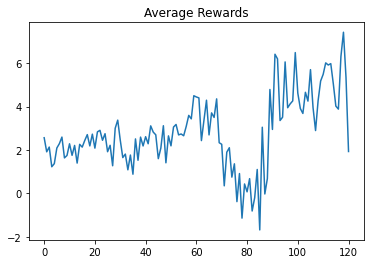

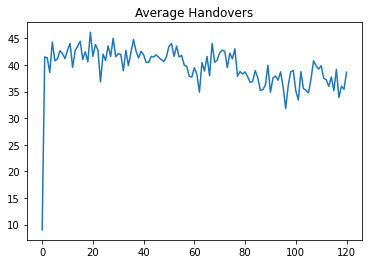

 65%|█████████████████████████████████████████████████▍                          | 13000/20000 [18:31<10:49, 10.77it/s]

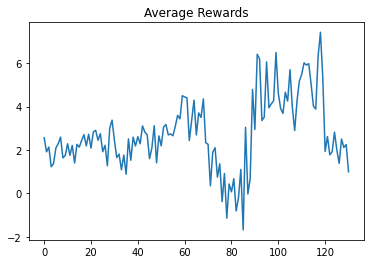

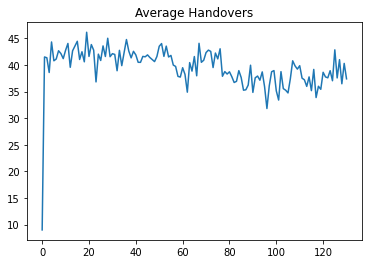

 70%|█████████████████████████████████████████████████████▏                      | 14000/20000 [19:54<07:50, 12.75it/s]

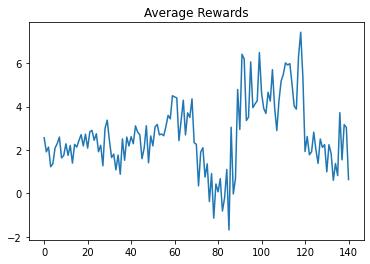

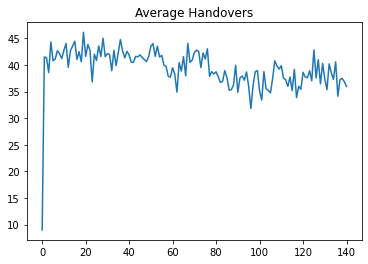

 71%|█████████████████████████████████████████████████████▉                      | 14202/20000 [20:11<08:10, 11.82it/s]

Saved new weights for reward of 8.118178994758951


 73%|███████████████████████████████████████████████████████▍                    | 14603/20000 [20:44<07:12, 12.48it/s]

Saved new weights for reward of 8.278919871048691


 74%|███████████████████████████████████████████████████████▊                    | 14702/20000 [20:52<07:30, 11.77it/s]

Saved new weights for reward of 10.134631749330211


 74%|████████████████████████████████████████████████████████▎                   | 14803/20000 [21:01<06:29, 13.36it/s]

Saved new weights for reward of 10.737621311409313


 75%|████████████████████████████████████████████████████████▉                   | 14999/20000 [21:17<07:07, 11.69it/s]

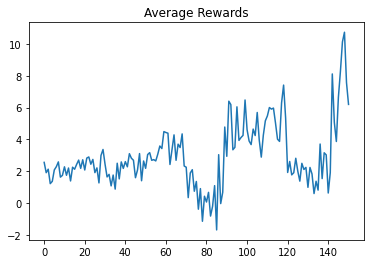

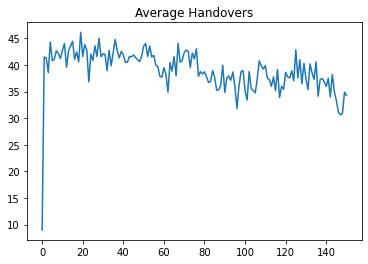

 80%|████████████████████████████████████████████████████████████▊               | 15999/20000 [22:40<06:00, 11.11it/s]

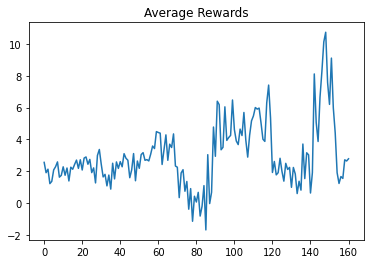

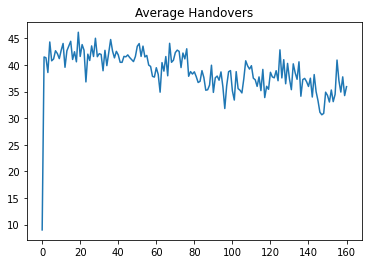

 85%|████████████████████████████████████████████████████████████████▌           | 16999/20000 [24:03<03:54, 12.82it/s]

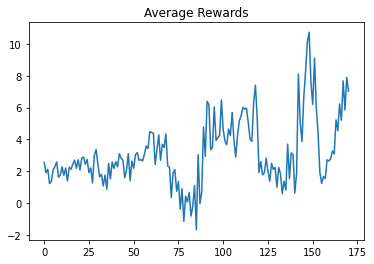

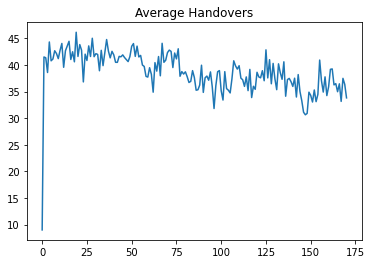

 90%|████████████████████████████████████████████████████████████████████▍       | 18000/20000 [25:26<03:24,  9.78it/s]

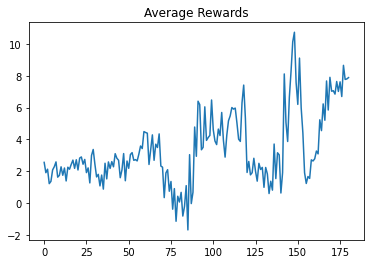

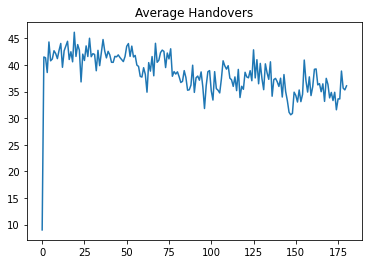

 92%|█████████████████████████████████████████████████████████████████████▌      | 18304/20000 [25:51<02:01, 13.92it/s]

Saved new weights for reward of 12.37467852635232


 95%|███████████████████████████████████████████████████████████████████████▊    | 18902/20000 [26:41<01:37, 11.22it/s]

Saved new weights for reward of 12.85232118248226


 95%|████████████████████████████████████████████████████████████████████████▏   | 19000/20000 [26:49<01:19, 12.55it/s]

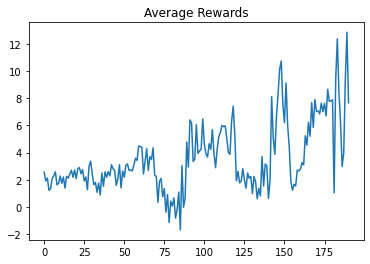

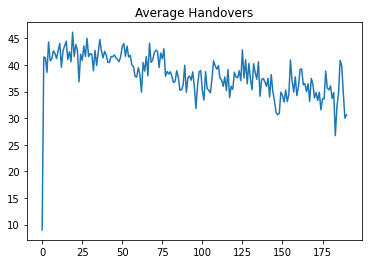

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [28:11<00:00, 11.82it/s]


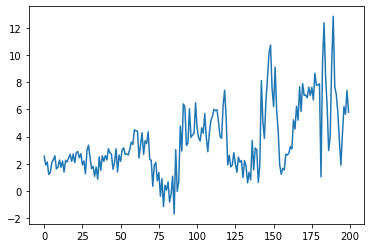

5.794527984818879


In [22]:
agent = agent_13
Wrsrp = 1
Who = 1/3
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_13.h5'

for episode in tqdm(range(20000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [23]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.52it/s]

-1.9347672885368048
38.2475


In [24]:
agent_23 = Agent(6, NUM_BASE_STATIONS)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 31)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1024      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32)              

  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]

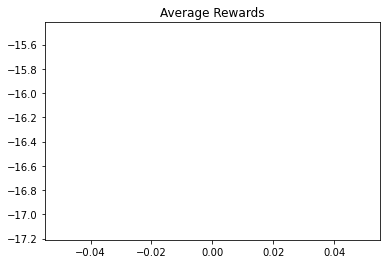

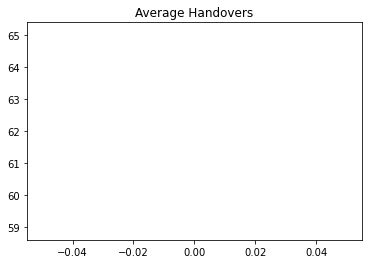

  5%|███▉                                                                          | 999/20000 [01:19<27:21, 11.58it/s]

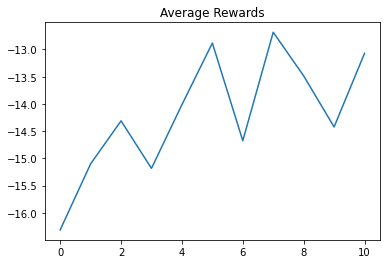

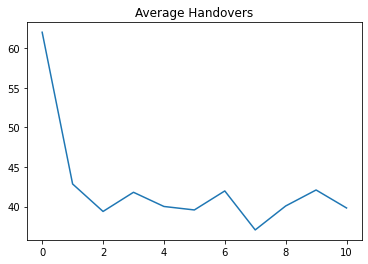

  5%|███▊                                                                         | 1003/20000 [01:19<35:39,  8.88it/s]

Saved new weights for reward of -13.071703613172867


  6%|████▋                                                                        | 1202/20000 [01:35<26:41, 11.74it/s]

Saved new weights for reward of -11.202475490976735


 10%|███████▋                                                                     | 2000/20000 [02:42<25:48, 11.62it/s]

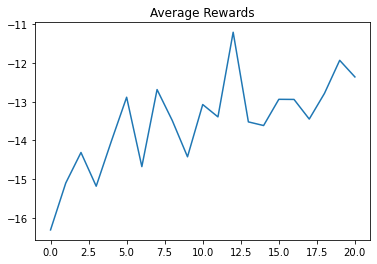

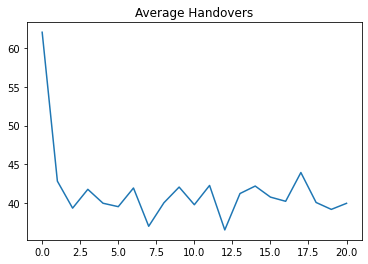

 15%|███████████▌                                                                 | 2999/20000 [04:05<23:36, 12.00it/s]

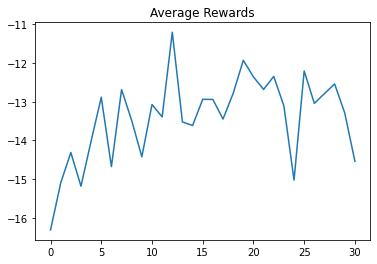

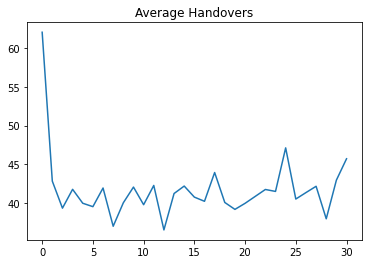

 17%|████████████▋                                                                | 3302/20000 [04:30<24:19, 11.44it/s]

Saved new weights for reward of -11.03443787627911


 20%|███████████████▍                                                             | 4000/20000 [05:27<21:32, 12.37it/s]

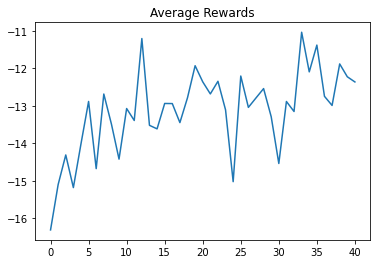

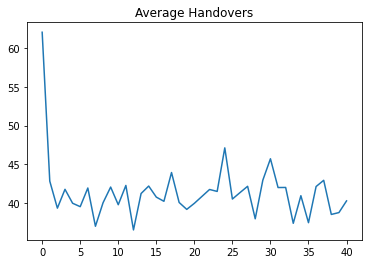

 21%|███████████████▊                                                             | 4102/20000 [05:35<23:09, 11.45it/s]

Saved new weights for reward of -10.560027056038946


 24%|██████████████████                                                           | 4702/20000 [06:24<20:16, 12.58it/s]

Saved new weights for reward of -9.698033547778955


 25%|██████████████████▊                                                          | 4902/20000 [06:40<20:39, 12.18it/s]

Saved new weights for reward of -8.067866468130415


 25%|███████████████████▎                                                         | 5000/20000 [06:48<20:27, 12.22it/s]

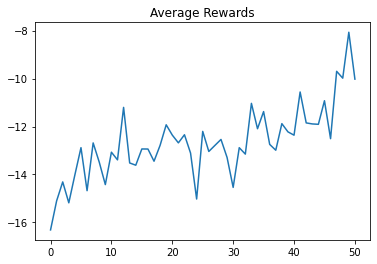

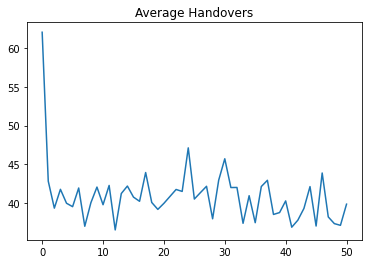

 28%|█████████████████████▏                                                       | 5502/20000 [07:31<23:36, 10.24it/s]

Saved new weights for reward of -7.2232601164718195


 29%|██████████████████████▎                                                      | 5802/20000 [07:56<17:23, 13.61it/s]

Saved new weights for reward of -5.529395787777093


 30%|███████████████████████                                                      | 6000/20000 [08:13<19:59, 11.67it/s]

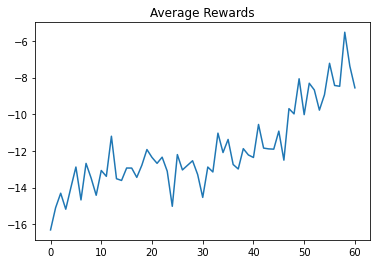

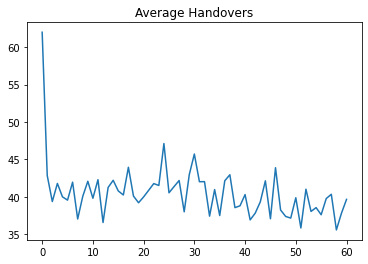

 32%|████████████████████████▎                                                    | 6302/20000 [08:38<17:37, 12.95it/s]

Saved new weights for reward of -3.0298538014806864


 32%|████████████████████████▋                                                    | 6402/20000 [08:47<19:39, 11.53it/s]

Saved new weights for reward of -1.821664462327346


 35%|██████████████████████████▉                                                  | 7000/20000 [09:37<20:25, 10.61it/s]

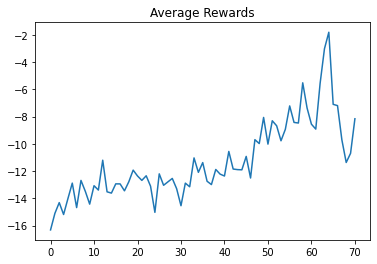

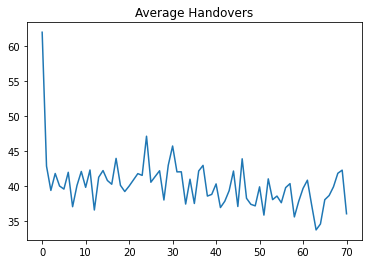

 37%|████████████████████████████▍                                                | 7402/20000 [10:15<21:57,  9.57it/s]

Saved new weights for reward of 0.8348873234449802


 40%|██████████████████████████████▊                                              | 8000/20000 [11:14<15:07, 13.22it/s]

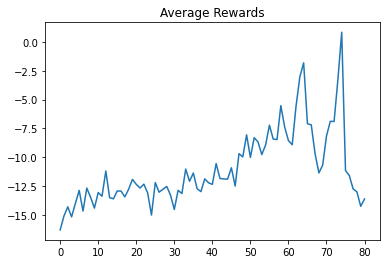

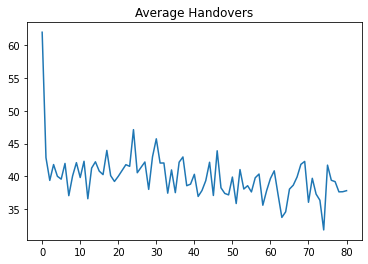

 45%|██████████████████████████████████▋                                          | 9000/20000 [12:43<14:36, 12.55it/s]

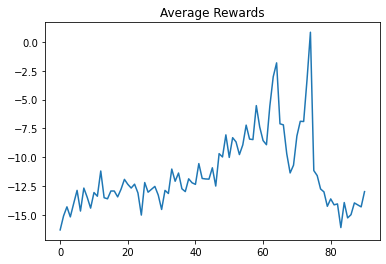

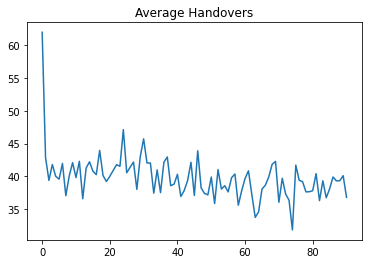

 50%|██████████████████████████████████████                                      | 10000/20000 [14:15<21:12,  7.86it/s]

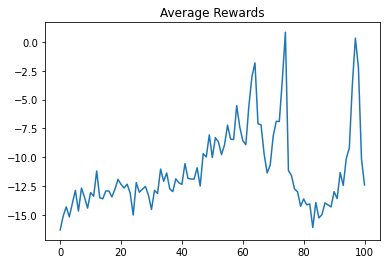

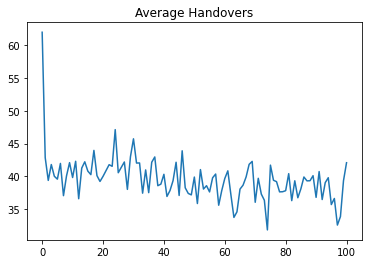

 55%|█████████████████████████████████████████▊                                  | 10999/20000 [15:41<11:05, 13.53it/s]

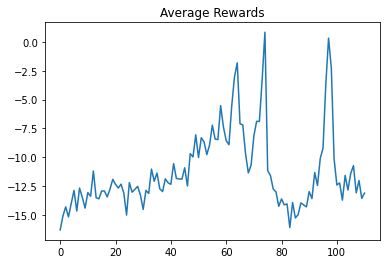

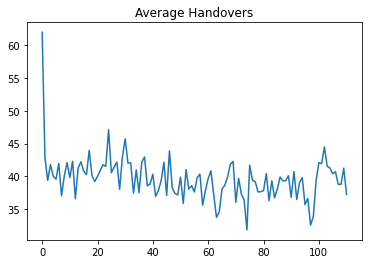

 60%|█████████████████████████████████████████████▌                              | 12000/20000 [17:19<18:28,  7.21it/s]

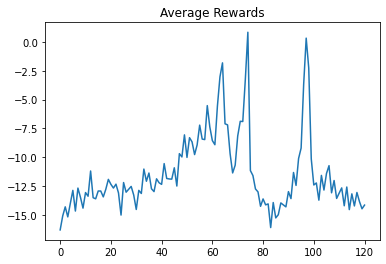

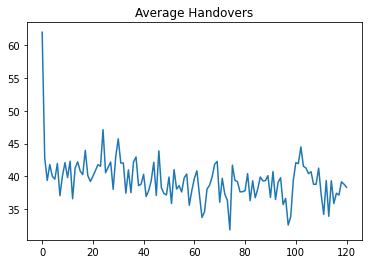

 65%|█████████████████████████████████████████████████▍                          | 13000/20000 [18:55<09:38, 12.09it/s]

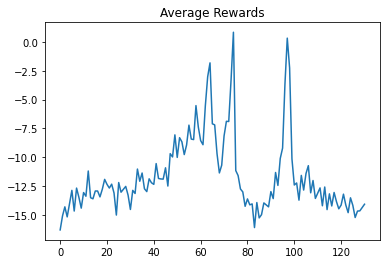

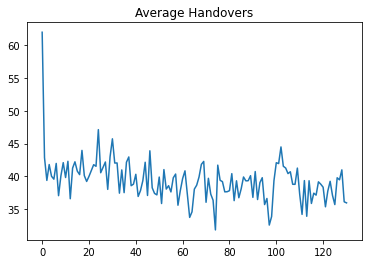

 70%|█████████████████████████████████████████████████████▏                      | 14000/20000 [20:19<07:39, 13.06it/s]

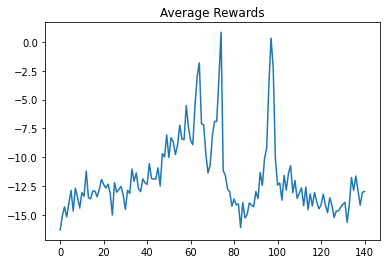

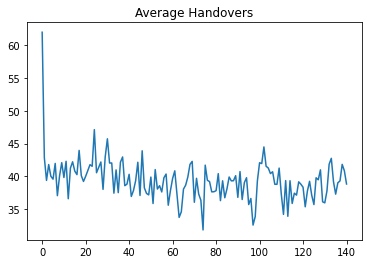

 75%|████████████████████████████████████████████████████████▉                   | 14999/20000 [21:41<07:59, 10.43it/s]

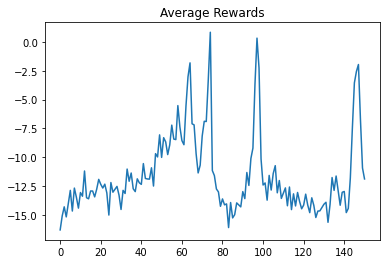

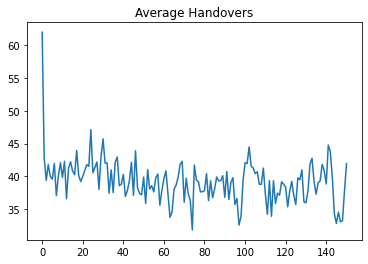

 76%|█████████████████████████████████████████████████████████▊                  | 15203/20000 [21:58<07:27, 10.73it/s]

Saved new weights for reward of 1.3018454461865465


 80%|████████████████████████████████████████████████████████████▊               | 16000/20000 [23:18<07:56,  8.40it/s]

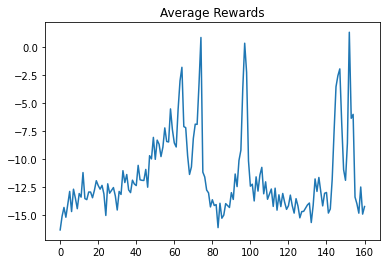

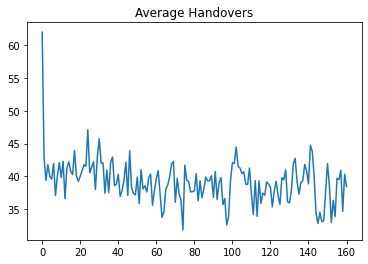

 85%|████████████████████████████████████████████████████████████████▌           | 17000/20000 [24:48<04:29, 11.12it/s]

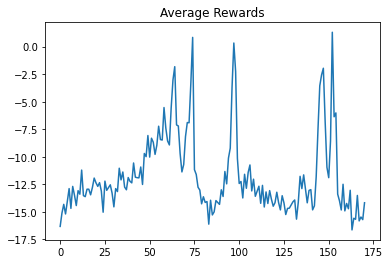

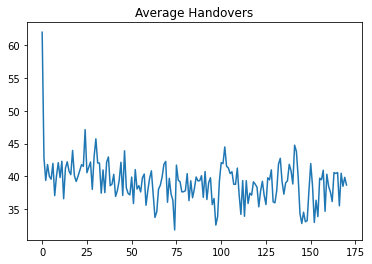

 88%|██████████████████████████████████████████████████████████████████▌         | 17503/20000 [25:30<03:36, 11.54it/s]

Saved new weights for reward of 2.6225967767723417


 90%|████████████████████████████████████████████████████████████████████▍       | 18000/20000 [26:12<03:35,  9.30it/s]

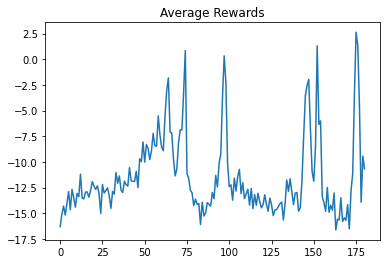

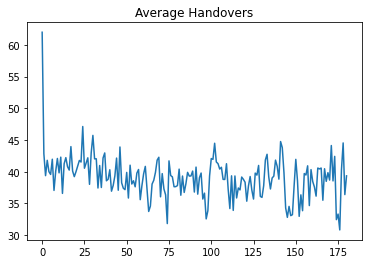

 95%|████████████████████████████████████████████████████████████████████████▏   | 19000/20000 [28:02<02:02,  8.13it/s]

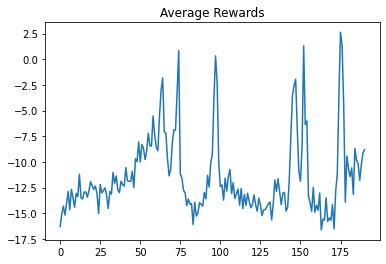

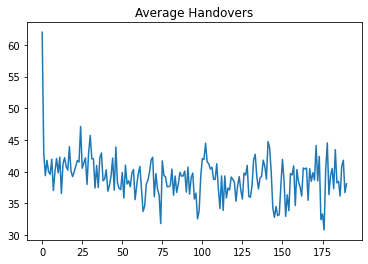

 96%|████████████████████████████████████████████████████████████████████████▌   | 19103/20000 [28:15<01:33,  9.57it/s]

Saved new weights for reward of 2.671207322197264


 96%|████████████████████████████████████████████████████████████████████████▉   | 19202/20000 [28:27<02:15,  5.90it/s]

Saved new weights for reward of 5.5940119874982


100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [29:40<00:00, 11.24it/s]


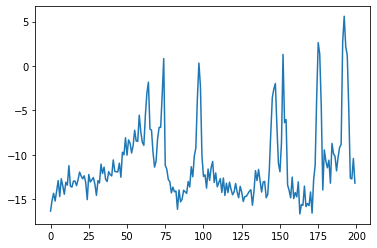

-13.168092696501567


In [25]:
agent = agent_23
Wrsrp = 1
Who = 2/3
last_r = []
rewards = []
hos = []
last_r_hos = []
r = 100
num_training_episode = 1
target_model_update = 100
max_reward = float('-inf')
path = 'agent_23.h5'

for episode in tqdm(range(20000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    action = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos+=1
    
    last_r_hos.append(num_hos)
    last_r.append(total_reward)
    
    if not episode%r:
        rewards.append(np.average(np.array(last_r)))
        hos.append(np.mean(last_r_hos))
        last_r = []
        last_r_hos = []
        
    if episode>50:
        agent.training_step(num_training_episode)
        
    if rewards[-1]>max_reward and episode>1000:
        max_reward = rewards[-1]
        agent.model.save_weights(path)
        print(f'Saved new weights for reward of {max_reward}')
            
    
    if episode%target_model_update==0:
        agent.target_model.set_weights(agent.model.get_weights())
    
    if episode%100==0:
        agent.epsilon*=0.99
        agent.epsilon = min(agent.epsilon, 0.05)
            
    if episode%1000==0:
        plt.plot(rewards)
        plt.title('Average Rewards')
        plt.show()
        plt.plot(hos)
        plt.title('Average Handovers')
        plt.show()
        
plt.plot(rewards)
plt.show()
print(rewards[-1])

In [26]:
agent.model.load_weights(path)
hos = []
rewards = []
agent.epsilon = 0
for episode in tqdm(range(2000)):
    src,dest = env.give_src_dest()
    route = env.compute_route(src, dest)
    state = route.popleft()
    depth = 3*NUM_BASE_STATIONS
    one_hot_cell = make_one_hot(env.sector_cells[src][0][0], depth)
    one_hot_direction = make_one_hot(state[-1]+1, 8)
    state = state[:-1]
    state.extend(one_hot_direction)
    state.extend(one_hot_cell) #Setting strongest cell as the initial serving cell (one_hot)
    done = 0
    total_reward = 0
    num_hos = 0
    
    while done==0:
        next_state, reward, done, change = agent.play_one_step(state, route, dest, Wrsrp, Who)
        total_reward+=reward
        state = next_state
        if change:
            num_hos +=1
    rewards.append(total_reward)
    hos.append(num_hos)

agent.mean_reward = np.mean(rewards) 
agent.mean_hos = np.mean(hos)

print(agent.mean_reward)
print(agent.mean_hos)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.43it/s]

0.048968067971519584
34.5635


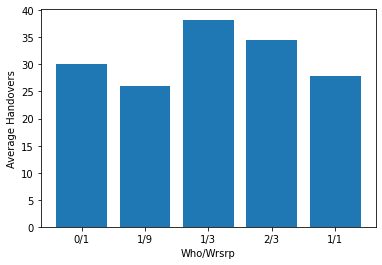

In [27]:
vals = [agent_0.mean_hos, agent_19.mean_hos, agent_13.mean_hos, agent_23.mean_hos,agent_1_1.mean_hos]
name = ['0/1', '1/9', '1/3', '2/3', '1/1']
plt.bar(name, vals)
plt.ylabel('Average Handovers')
plt.xlabel('Who/Wrsrp')
plt.show()